# Brain讲 分类 Classification with Transfer learning



In [40]:
import os
import cv2
import glob
import random
import imageio
import numpy as np
import pandas as pd
from PIL import Image
import seaborn as sns
import skimage.measure   
import tensorflow as tf
from skimage import data
import albumentations as A
import scipy.ndimage as ndi
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from keras.models import Sequential
from skimage.morphology import disk
from skimage.util import img_as_ubyte
from skimage.filters.rank import entropy
from tensorflow.keras import regularizers
from skimage.measure.entropy import shannon_entropy
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam , Adamax
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix , classification_report
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense,BatchNormalization

In [41]:
train_glioma = glob.glob('C:/Users/almog/Almog_codes/Anaconda/Code_in_Python/Neural_networks/ANN_Final_Project/Data_to_FP/Training/glioma_tumor/*.jpg')
train_menignioma = glob.glob('C:/Users/almog/Almog_codes/Anaconda/Code_in_Python/Neural_networks/ANN_Final_Project/Data_to_FP/Training/meningioma_tumor/*.jpg')
train_pituitary = glob.glob('C:/Users/almog/Almog_codes/Anaconda/Code_in_Python/Neural_networks/ANN_Final_Project/Data_to_FP/Training/meningioma_tumor/*.jpg')
train_no = glob.glob('C:/Users/almog/Almog_codes/Anaconda/Code_in_Python/Neural_networks/ANN_Final_Project/Data_to_FP/Training/no_tumor/*.jpg')

#Test
test_glioma = glob.glob('C:/Users/almog/Almog_codes/Anaconda/Code_in_Python/Neural_networks/ANN_Final_Project/Data_to_FP/Testing/glioma_tumor/*.jpg')
test_menignioma = glob.glob('C:/Users/almog/Almog_codes/Anaconda/Code_in_Python/Neural_networks/ANN_Final_Project/Data_to_FP/Testing/meningioma_tumor/*.jpg')
test_pituitary = glob.glob('C:/Users/almog/Almog_codes/Anaconda/Code_in_Python/Neural_networks/ANN_Final_Project/Data_to_FP/Testing/pituitary_tumor/*.jpg')
test_no = glob.glob('C:/Users/almog/Almog_codes/Anaconda/Code_in_Python/Neural_networks/ANN_Final_Project/Data_to_FP/Testing/no_tumor/*.jpg')

In [8]:
train_glioma_number = len(train_glioma)
train_menignioma_number = len(train_menignioma)
train_pituitary_number = len(train_pituitary)
train_no_number = len(train_no)

test_glioma_number = len(test_glioma)
test_menignioma_number = len(test_menignioma)
test_pituitary_number = len(test_pituitary)
test_no_number = len(test_no)

print("Number of train_glioma: ",train_glioma_number)
print("Number of train_menignioma: ",train_menignioma_number)
print("Number of train_pituitary: ",train_pituitary_number)
print("Number of train_no: ",train_no_number)
print("Number of test_glioma: ",test_glioma_number)
print("Number of test_menignioma: ",train_menignioma_number)
print("Number of test_pituitary: ",train_pituitary_number)
print("Number of test_no: ",train_no_number)

Number of train_glioma:  826
Number of train_menignioma:  822
Number of train_pituitary:  822
Number of train_no:  395
Number of test_glioma:  100
Number of test_menignioma:  822
Number of test_pituitary:  822
Number of test_no:  395


### ניסיון לאיזון גודל המחלקות

In [28]:
train_data_path = 'C:/Users/almog/Almog_codes/Anaconda/Code_in_Python/Neural_networks/ANN_Final_Project/Data_to_FP/Bdika'

filepaths =[]
labels = []
folds = os.listdir(train_data_path)

for fold in folds:
    f_path = os.path.join(train_data_path , fold)
    filelists = os.listdir(f_path)
    
    for file in filelists:
        filepaths.append(os.path.join(f_path , file))
        labels.append(fold)
        
#Concat data paths with labels
Fseries = pd.Series(filepaths , name = 'filepaths')
Lseries = pd.Series(labels , name = 'label')
train_df = pd.concat([Fseries , Lseries] , axis = 1)



In [29]:
class_counts = train_df['label'].value_counts()
print(class_counts)



label
glioma_tumor        3500
meningioma_tumor    3500
no_tumor            3500
pituitary_tumor     3500
Name: count, dtype: int64


In [9]:
# בודק כמה יש מכל מחלקה אימון ומבחן
print("Number of glioma: ",train_glioma_number + test_glioma_number)
print("Number of menignioma: ",train_menignioma_number+ test_menignioma_number)
print("Number of pituitary: ",train_pituitary_number+ test_pituitary_number)
print("Number of no_tumor: ",train_no_number + test_no_number)




Number of glioma:  926
Number of menignioma:  937
Number of pituitary:  896
Number of no_tumor:  500


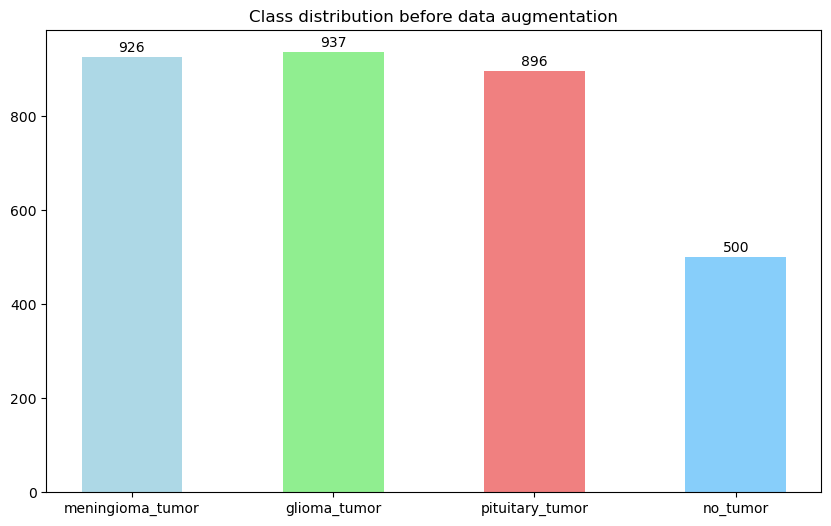

In [66]:
# בודק כמה יש מכל מחלקה אימון ומבחן
glioma_ALL = train_glioma_number + test_glioma_number
menignioma_ALL =train_menignioma_number+ test_menignioma_number
pituitary_ALL =train_pituitary_number+ test_pituitary_number
no_number =train_no_number + test_no_number


sizes = [glioma_ALL, menignioma_ALL, pituitary_ALL, no_number]
labels = ['meningioma_tumor', 'glioma_tumor', 'pituitary_tumor', 'no_tumor']

pastel_colors = ['lightblue', 'lightgreen', 'lightcoral', 'lightskyblue']

# הגדרת רוחב קטן יותר לעמודות
bar_width = 0.5  # רוחב העמודות
# קונפיגורציה של הגרף עם רוחב העמודות החדש
fig, ax = plt.subplots(figsize=(10, 6))  # שינוי בגודל הגרף לרוחב 10 אינצ' וגובה 6 אינצ'
bars = ax.bar(labels, sizes, color=pastel_colors, width=bar_width)

# הוספת טקסט לעמודות
for bar in bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar_width/2, yval + 5, yval, ha='center', va='bottom')

# הגדרת כותרת לגרף
ax.set_title('Class distribution before data augmentation')

# הצגת הגרף
plt.show()


In [2]:
# מכולל תמונות
import os
import cv2
import numpy as np
import albumentations as A

def augment_images(folder_path, num_images):
    # Define data augmentation transforms
    transform = A.Compose([
        A.HueSaturationValue(p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        A.RandomGamma(p=0.5),
        A.Flip(p=0.5),
        A.Rotate(p=0.5),
        A.MultiplicativeNoise(multiplier=[0.5, 1.5], elementwise=True, per_channel=True, p=0.5),
        A.ShiftScaleRotate(shift_limit=0.0625, rotate_limit=45, p=0.5),
        A.Transpose(p=0.5),
    ])

    # Load original images
    original_images = [cv2.imread(os.path.join(folder_path, filename))
                       for filename in os.listdir(folder_path) if filename.endswith('.jpg')]
    original_images = [cv2.resize(img, (256, 256)) for img in original_images]

    num_original_images = len(original_images)
    print(f"Number of original images in : {num_original_images}")

    # If there are less than num_images, augment to reach num_images
    if num_original_images < num_images:
        num_augmentations_needed = num_images - num_original_images
        augmented_images = original_images.copy()
        for img in original_images:
            for _ in range(num_augmentations_needed):
                augmented = transform(image=img)['image']
                augmented_images.append(augmented)
                num_augmentations_needed -= 1
                if num_augmentations_needed == 0:
                    break

        # Save augmented images in the same folder
        for i, aug_img in enumerate(augmented_images, start=num_original_images):
            save_path = os.path.join(folder_path, f"{i}.jpg")
            cv2.imwrite(save_path, aug_img)
    else:
        print(f"No augmentation needed for {folder_path}, as there are already {num_original_images} images.")

    print(f"Number of images after augmentation: {len(os.listdir(folder_path))}")



In [34]:
# Specify the path to the parent folder containing subfolders
parent_folder_path = 'C:/Users/almog/Almog_codes/Anaconda/Code_in_Python/Neural_networks/ANN_Final_Project/Data_to_FP/bdika'
num_images= 2000

# Loop through subfolders
for subfolder_name in os.listdir(parent_folder_path):    
    subfolder_path = os.path.join(parent_folder_path, subfolder_name)
    if os.path.isdir(subfolder_path):
        # Get the number of files in the subfolder
        num_files = len([name for name in os.listdir(subfolder_path) if os.path.isfile(os.path.join(subfolder_path, name))])
        if num_files < num_images :
            # Now call the augment_images function
            augment_images(subfolder_path, num_images)


In [44]:
data_path = 'C:/Users/almog/Almog_codes/Anaconda/Code_in_Python/Neural_networks/ANN_Final_Project/Data_to_FP/Bdika'

filepaths =[]
labels = []
folds = os.listdir(train_data_path)

for fold in folds:
    f_path = os.path.join(train_data_path , fold)
    filelists = os.listdir(f_path)
    
    for file in filelists:
        filepaths.append(os.path.join(f_path , file))
        labels.append(fold)
        
#Concat data paths with labels
Fseries = pd.Series(filepaths , name = 'filepaths')
Lseries = pd.Series(labels , name = 'label')
data_df = pd.concat([Fseries , Lseries] , axis = 1)


In [36]:
class_counts = data_df['label'].value_counts()
print(class_counts)


label
glioma_tumor        3500
meningioma_tumor    3500
no_tumor            3500
pituitary_tumor     3500
Name: count, dtype: int64


In [37]:
meningioma_tumor = data_df['label'].value_counts()['meningioma_tumor']
glioma_tumor = data_df['label'].value_counts()['glioma_tumor']
pituitary_tumor = data_df['label'].value_counts()['pituitary_tumor']
no_tumor = data_df['label'].value_counts()['no_tumor']

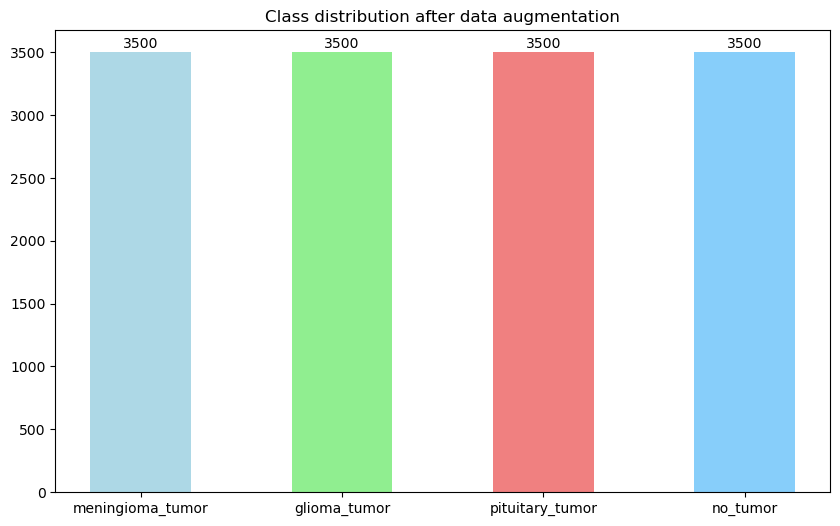

In [39]:
sizes = [meningioma_tumor, glioma_tumor, pituitary_tumor, no_tumor]
labels = ['meningioma_tumor', 'glioma_tumor', 'pituitary_tumor', 'no_tumor']

pastel_colors = ['lightblue', 'lightgreen', 'lightcoral', 'lightskyblue']

# הגדרת רוחב קטן יותר לעמודות
bar_width = 0.5  # רוחב העמודות
# קונפיגורציה של הגרף עם רוחב העמודות החדש
fig, ax = plt.subplots(figsize=(10, 6))  # שינוי בגודל הגרף לרוחב 10 אינצ' וגובה 6 אינצ'
bars = ax.bar(labels, sizes, color=pastel_colors, width=bar_width)

# הוספת טקסט לעמודות
for bar in bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar_width/2, yval + 10, yval, ha='center', va='bottom')

# הגדרת כותרת לגרף
ax.set_title('Class distribution after data augmentation')

# הצגת הגרף
plt.show()


In [64]:
print("Time to evaluate test accuracy and test loss 8.60243319906616 seconds")

Time to evaluate test accuracy and test loss 8.60243319906616 seconds


In [65]:
print("Time to predict test  23.605389906616 seconds")

Time to predict test  23.605389906616 seconds


### המשך הקוד

In [ ]:
import matplotlib.pyplot as plt
from bidi import algorithm as bidi_algorithm

# צבעים פסטל וקרים
pastel_colors = ['#FFDAB9', '#FFA07A', '#ADD8E6', '#98FB98']

# גודל גרפים
plt.figure(figsize=(12, 4))

# גרף לאימון
plt.subplot(1, 3, 1)
plt.title(bidi_algorithm.get_display("סט אימון - חלוקה לפי מחלקות"))
plt.pie([train_glioma_number, train_menignioma_number, train_pituitary_number, train_no_number],
        labels=['Glioma', 'Menignioma', 'Pituitary', 'No tumor'],
        colors=pastel_colors, autopct='%.1f%%', explode=(0.025, 0.025, 0.025, 0.025),
        startangle=30)

# גרף למבחן
plt.subplot(1, 3, 2)
plt.title(bidi_algorithm.get_display("סט מבחן - חלוקה לפי מחלקות"))
plt.pie([test_glioma_number, test_menignioma_number, test_pituitary_number, test_no_number],
        labels=['Glioma', 'Menignioma', 'Pituitary', 'No tumor'],
        colors=pastel_colors, autopct='%.1f%%', explode=(0.025, 0.025, 0.025, 0.025),
        startangle=30)

# גרף אימון מול מבחן
plt.subplot(1, 3, 3)
plt.title(bidi_algorithm.get_display("השוואה בין אימון למבחן"))
plt.pie([test_glioma_number + test_menignioma_number + test_pituitary_number + test_no_number,
         train_glioma_number + train_menignioma_number + train_pituitary_number + train_no_number],
        labels=['Testing', 'Training'],
        colors=pastel_colors[:2], autopct='%.1f%%', explode=(0.025, 0.025),
        startangle=30)

# הצגת הגרפים
plt.tight_layout()
plt.show()


In [42]:
def images_visualization(image, title,a):#a=number of images
    plt.figure(figsize=(8,8))#image size
    for i in range(a):#number of image
        random_image_path = random.choice(image)#random selection
        img = mpimg.imread(random_image_path)
        plt.subplot(1, a, i+1)
        plt.imshow(img, cmap='gray')
        plt.axis('off')
        plt.title(title)
    plt.show()

In [ ]:
print("Train image visualisation\n")
images_visualization(train_glioma, 'Glioma',3)
images_visualization(train_menignioma, 'Menignioma',3)
images_visualization(train_pituitary, 'Pituitary',3)
images_visualization(train_no, 'No-Tumor',3)

In [ ]:
def fiter(image, title,a,m):#a=number of images, m = filter matrix
    plt.figure(figsize=(8,8))#image size
    for i in range(a):#number of image
        random_image_path = random.choice(image)#random selection
        img = cv2.imread(random_image_path) # read the image using cv2
        laplacian_kernel = np.array(m) # define the Laplacian kernel
        laplacian_img = cv2.filter2D(img, -1, laplacian_kernel) # apply the Laplacian filter using cv2.filter2D
        plt.subplot(1, a, i+1)
        plt.imshow(laplacian_img, cmap='jet') # display the filtered image using plt.imshow and cmap='jet'
        plt.axis('off')
        plt.title(title)
    plt.show()

In [ ]:
m = [[1, 1, 1], [1, 1, 1], [1, 1, 1]]# Gaussian filter 

fiter(train_glioma, 'Glioma',3,m)
fiter(train_menignioma, 'Menignioma',3,m)
fiter(train_pituitary, 'Pituitary',3,m)
fiter(train_no, 'No-Tumor',3,m)

In [ ]:
#m = [[1, 1, 1], [1, 1, 1], [1, 1, 1]]# Gaussian filter 
#m = np.array([[-1, -1, -1], [-1, 9, -1], [-1, -1, -1]])
m =  [[1, 1, 1], [1, -8, 1], [1, 1, 1]]#laplacian of Gaussian filter 

fiter(train_glioma, 'Glioma',3,m)
fiter(train_menignioma, 'Menignioma',3,m)
fiter(train_pituitary, 'Pituitary',3,m)
fiter(train_no, 'No-Tumor',3,m)

In [ ]:
def clahe(image, title,a):#a=number of images
    plt.figure(figsize=(8,8))#image size
    for i in range(a):#number of image
        random_image_path = random.choice(image)#random selection
        img = cv2.imread(random_image_path) # read the image using cv2
        img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # convert the image to grayscale
        clahe = cv2.createCLAHE(clipLimit=5, tileGridSize=(8,8)) # create a CLAHE object with clip limit and tile grid size
        clahe_img = clahe.apply(img_gray) # apply CLAHE to the grayscale image
        plt.subplot(1, a, i+1)
        plt.imshow(clahe_img, cmap='jet') # display the filtered image using plt.imshow and cmap='jet'
        plt.axis('off')
        plt.title(title)
    plt.show()

In [ ]:
clahe(train_glioma, 'Glioma',3)
clahe(train_menignioma, 'Menignioma',3)
clahe(train_pituitary, 'Pituitary',3)
clahe(train_no,'No-Tumor',3)

# Image preprocessing

In [45]:
train_data_path = 'C:/Users/almog/Almog_codes/Anaconda/Code_in_Python/Neural_networks/ANN_Final_Project/Data_to_FP/Training'

filepaths =[]
labels = []

folds = os.listdir(train_data_path)

for fold in folds:
    f_path = os.path.join(train_data_path , fold)
    filelists = os.listdir(f_path)
    
    for file in filelists:
        filepaths.append(os.path.join(f_path , file))
        labels.append(fold)
        
#Concat data paths with labels
Fseries = pd.Series(filepaths , name = 'filepaths')
Lseries = pd.Series(labels , name = 'label')
train_df = pd.concat([Fseries , Lseries] , axis = 1)

train_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2870 entries, 0 to 2869
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   filepaths  2870 non-null   object
 1   label      2870 non-null   object
dtypes: object(2)
memory usage: 45.0+ KB


In [46]:
test_data_path = 'C:/Users/almog/Almog_codes/Anaconda/Code_in_Python/Neural_networks/ANN_Final_Project/Data_to_FP/Testing'

filepaths =[]
labels = []

folds = os.listdir(test_data_path)

for fold in folds:
    f_path = os.path.join(test_data_path , fold)
    filelists = os.listdir(f_path)
    
    for file in filelists:
        filepaths.append(os.path.join(f_path , file))
        labels.append(fold)
        
#Concat data paths with labels
Fseries = pd.Series(filepaths , name = 'filepaths')
Lseries = pd.Series(labels , name = 'label')
test_df = pd.concat([Fseries , Lseries] , axis = 1)

test_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 394 entries, 0 to 393
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   filepaths  394 non-null    object
 1   label      394 non-null    object
dtypes: object(2)
memory usage: 6.3+ KB


### איחוד הקבצים ודאטה אוגמנטיישן

In [ ]:
# איחוד בניהם
combined_df = pd.concat([train_df, test_df], ignore_index=True)
combined_df.info()

In [ ]:
class_counts = combined_df['label'].value_counts()
print(class_counts)

In [ ]:
# מספרי הדוגמאות לכל מחלקה
meningioma_tumor = combined_df['label'].value_counts()['meningioma_tumor']
glioma_tumor = combined_df['label'].value_counts()['glioma_tumor']
pituitary_tumor = combined_df['label'].value_counts()['pituitary_tumor']
no_tumor = combined_df['label'].value_counts()['no_tumor']

print("Meningioma Tumor:", meningioma_tumor)
print("Glioma Tumor:", glioma_tumor)
print("Pituitary Tumor:", pituitary_tumor)
print("No Tumor:", no_tumor)


In [ ]:
import matplotlib.pyplot as plt

# יצירת רשימות עבור המחלקות והמספרים שלהן
classes = ['meningioma_tumor', 'glioma_tumor', 'pituitary_tumor', 'no_tumor']
counts = [meningioma_tumor, glioma_tumor, pituitary_tumor, no_tumor]

# יצירת גרף מברים
plt.bar(classes, counts)
plt.xlabel('מחלקות')
plt.ylabel('מספר דוגמאות')
plt.title('כמות דוגמאות לכל מחלקה')
plt.show()


In [ ]:
bdika_data_path = 'C:/Users/almog/Almog_codes/Anaconda/Code_in_Python/Neural_networks/ANN_Final_Project/Data_to_FP/Bdika'

filepaths =[]
labels = []

folds = os.listdir(bdika_data_path)

for fold in folds:
    f_path = os.path.join(bdika_data_path , fold)
    filelists = os.listdir(f_path)
    
    for file in filelists:
        filepaths.append(os.path.join(f_path , file))
        labels.append(fold)
        
#Concat data paths with labels
Fseries = pd.Series(filepaths , name = 'filepaths')
Lseries = pd.Series(labels , name = 'label')
Bdika_df = pd.concat([Fseries , Lseries] , axis = 1)

Bdika_df.info()

# מספרי הדוגמאות לכל מחלקה
meningioma_tumor = Bdika_df['label'].value_counts()['meningioma_tumor']
glioma_tumor = Bdika_df['label'].value_counts()['glioma_tumor']
pituitary_tumor = Bdika_df['label'].value_counts()['pituitary_tumor']
no_tumor = Bdika_df['label'].value_counts()['no_tumor']

print("Meningioma Tumor:", meningioma_tumor)
print("Glioma Tumor:", glioma_tumor)
print("Pituitary Tumor:", pituitary_tumor)
print("No Tumor:", no_tumor)

import matplotlib.pyplot as plt

# יצירת רשימות עבור המחלקות והמספרים שלהן
classes = ['meningioma_tumor', 'glioma_tumor', 'pituitary_tumor', 'no_tumor']
counts = [meningioma_tumor, glioma_tumor, pituitary_tumor, no_tumor]

# יצירת גרף מברים
plt.bar(classes, counts)
plt.xlabel('מחלקות')
plt.ylabel('מספר דוגמאות')
plt.title('כמות דוגמאות לכל מחלקה')
plt.show()


In [ ]:
Bdika_df.head(5)

### ניסיון לאיזון

In [ ]:
import numpy as np
import albumentations as A

# Define data augmentation transforms
transform = A.Compose([
    A.HueSaturationValue(p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.RandomGamma(p=0.5),
    A.Flip(p=0.5),
    A.Rotate(p=0.5),
    A.MultiplicativeNoise(multiplier=[0.5, 1.5], elementwise=True, per_channel=True, p=0.5),
    A.ShiftScaleRotate(shift_limit=0.0625, rotate_limit=45, p=0.5),
    A.Transpose(p=0.5),
])



import cv2

def balance_data(df, max_samples_per_class):
    balanced_data = []
    num = 1

    for _, row in df.iterrows():
        num_samples = df['label'].value_counts()[row['label']]
        if num_samples <= max_samples_per_class:
            num_augmentations = max_samples_per_class - num_samples
            for i in range(num_augmentations):
                image = cv2.imread(row['filepaths'])  # קריאה של התמונה בעזרת OpenCV
                augmented_image = transform(image=image)['image']
                balanced_data.append(augmented_image)
            # הדפסת מספר התמונות שעברו עבור המחלקה
            print(f"{num} images done frome processed of {num_augmentations} images in class {row['label']}")
            num  = num +1
        else:
            balanced_data.append(cv2.imread(row['filepaths']))
    return pd.DataFrame({'filepaths': balanced_data})

max_samples_per_class = 10
balanced_train_df = balance_data(Bdika_df, max_samples_per_class)




In [ ]:
from sklearn.utils import resample
import pandas as pd

# Assuming Bdika_df is already defined with 'filepaths' and 'label' columns

def balance_data(df, max_samples_per_class):
    # Initialize balanced dataframe
    balanced_df = pd.DataFrame(columns=df.columns)

    # Iterate over each class
    for class_label in df['label'].unique():
        class_df = df[df['label'] == class_label]
        num_samples = len(class_df)
        
        # If the class has fewer samples than max_samples_per_class, resample it
        if num_samples < max_samples_per_class:
            oversampled_class = resample(class_df, replace=True, n_samples=max_samples_per_class - num_samples)
            class_df = pd.concat([class_df, oversampled_class])
        
        # Append the balanced class to the balanced dataframe
        balanced_df = pd.concat([balanced_df, class_df])
    
    return balanced_df

max_samples_per_class = 10
balanced_train_df = balance_data(Bdika_df, max_samples_per_class)


In [ ]:
balanced_train_df.info()
class_counts = balanced_train_df['label'].value_counts()
print(class_counts)

In [ ]:
balanced_train_df.head(5)

In [ ]:
import os
import cv2
import pandas as pd

# Assuming balanced_train_df is the balanced dataframe containing filepaths and labels

# Create a directory to save the images divided by classes
save_dir = 'balanced_images'
os.makedirs(save_dir, exist_ok=True)

# Iterate over the unique class labels and create a directory for each class
for class_label in balanced_train_df['label'].unique():
    class_dir = os.path.join(save_dir, class_label)
    os.makedirs(class_dir, exist_ok=True)

# Iterate over the dataframe rows and save each image with its label in the corresponding class directory
for index, row in balanced_train_df.iterrows():
    img = cv2.imread(row['filepaths'])
    label = row['label']
    save_path = os.path.join(save_dir, label, f"{label}_{index}.jpg")
    cv2.imwrite(save_path, img)


### המשך קוד ישן

In [48]:
valid , test = train_test_split(test_df , train_size = 0.5 , shuffle = True , random_state= 42)


In [49]:
img_size = (220 ,220)#This defines a variable called img_size that stores a tuple of two integers, 220 and 220. This will be used as the target size for resizing the images.
batch_size = 15 # This defines a variable called batch_size that stores an integer, 16. This will be used as the number of images per batch.

tr_gen = ImageDataGenerator()#This creates an instance of the ImageDataGenerator class and assigns it to a variable called tr_gen. This will be used to create the train_gen object later. By default, this does not apply any preprocessing or augmentation to the images, but you can pass some arguments to the constructor to customize it.
ts_gen= ImageDataGenerator()

train_gen = tr_gen.flow_from_dataframe(train_df , x_col = 'filepaths' , y_col = 'label' , target_size = img_size ,
                                      class_mode = 'categorical' , color_mode = 'rgb' , shuffle = True , batch_size =batch_size)

valid_gen = ts_gen.flow_from_dataframe(valid , x_col = 'filepaths' , y_col = 'label' , target_size = img_size , 
                                       class_mode = 'categorical',color_mode = 'rgb' , shuffle= True, batch_size = batch_size)

test_gen = ts_gen.flow_from_dataframe(test , x_col= 'filepaths' , y_col = 'label' , target_size = img_size , 
                                      class_mode = 'categorical' , color_mode= 'rgb' , shuffle = False , batch_size = batch_size)

Found 2870 validated image filenames belonging to 4 classes.
Found 197 validated image filenames belonging to 4 classes.
Found 197 validated image filenames belonging to 4 classes.


In [51]:
images , labels = next(train_gen)

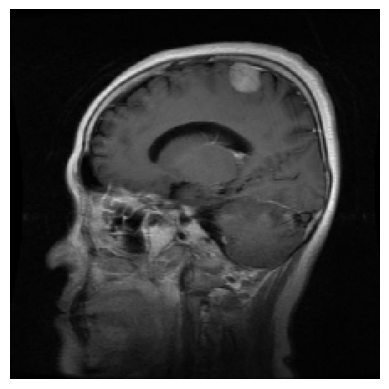

In [60]:
import matplotlib.pyplot as plt
import numpy as np

def display_image(image):
    # אם הערכים מחוץ לטווח [0, 1], נבצע המרה לטווח החוקי
    if np.max(image) > 1.0:
        image = image / 255.0  # להפוך ערכים מ-uint8 ל-floats בטווח [0, 1]
    
    plt.imshow(image)
    plt.axis('off')
    plt.show()



display_image(images[14])


In [ ]:
base_model.summary()

In [ ]:
#בניית המודל

In [67]:
gen_dict = train_gen.class_indices
classes = list(gen_dict.keys())
images , labels = next(train_gen)
img_shape = (img_size[0] , img_size[1] , 3)
num_class = len(classes)

base_model = tf.keras.applications.efficientnet.EfficientNetB3(include_top = False , weights = 'imagenet' ,

                                                               input_shape = img_shape, pooling= 'max')
model = Sequential([
    base_model,
    BatchNormalization(axis= -1 , momentum= 0.99 , epsilon= 0.001),
    Dense(256, kernel_regularizer = regularizers.l2(0.016) , activity_regularizer = regularizers.l1(0.006),
         bias_regularizer= regularizers.l1(0.006) , activation = 'relu'),
    Dropout(rate= 0.4 , seed = 75),
    Dense(num_class , activation = 'softmax')
])

#optimizer
model.compile(Adamax(learning_rate = 0.001) , loss = 'categorical_crossentropy', metrics = ['accuracy'])
model.summary()




Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb3 (Functional  (None, 1536)              10783535  
 )                                                               
                                                                 
 batch_normalization (Batch  (None, 1536)              6144      
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 256)               393472    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 4)                 1028      
                                                                 
Total params: 11184179 (42.66 MB)
Trainable params: 1

In [ ]:
Epochs = 8

history_op1 = model.fit(x= train_gen , epochs = Epochs , verbose = 1 , validation_data = valid_gen ,
                   validation_steps = None , shuffle = False)

In [ ]:
history_dict_op1 = history_op1.history
val_loss_op1 = history_dict_op1['val_loss']
train_loss_op1 = history_dict_op1['loss']
val_accuracy_op1 = history_dict_op1['val_accuracy']
train_accuracy_op1 = history_dict_op1['accuracy']
plt.figure(figsize=(15,6))


# Plotting the training and validation loss
plt.subplot(1, 2, 1)
plt.plot(train_loss_op1, label='Train Loss', color='#8502d1')
plt.plot(val_loss_op1, label='Validation Loss', color='darkorange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Evolution')

# Plotting the training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracy_op1, label='Train Accuracy', color='#8502d1')
plt.plot(val_accuracy_op1, label='Validation Accuracy', color='darkorange')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Evolution')

plt.suptitle('OP_1 - With data augmentation and Including the 7 and 8 convolutional layer', fontsize=16)

plt.show()

# קוד לבורה

In [ ]:
# קוד לשלוח לבורה

train_data_path = '/kaggle/input/brain-tumor-classification-mri/Training'

filepaths =[]
labels = []
folds = os.listdir(train_data_path)

for fold in folds:
    f_path = os.path.join(train_data_path , fold)
    filelists = os.listdir(f_path)
    
    for file in filelists:
        filepaths.append(os.path.join(f_path , file))
        labels.append(fold)
        
#Concat data paths with labels
Fseries = pd.Series(filepaths , name = 'filepaths')
Lseries = pd.Series(labels , name = 'label')
train_df = pd.concat([Fseries , Lseries] , axis = 1)

test_data_path = '/kaggle/input/brain-tumor-classification-mri/Testing'

filepaths =[]
labels = []

folds = os.listdir(test_data_path)

for fold in folds:
    f_path = os.path.join(test_data_path , fold)
    filelists = os.listdir(f_path)
    
    for file in filelists:
        filepaths.append(os.path.join(f_path , file))
        labels.append(fold)
        
#Concat data paths with labels
Fseries = pd.Series(filepaths , name = 'filepaths')
Lseries = pd.Series(labels , name = 'label')
test_df = pd.concat([Fseries , Lseries] , axis = 1)

# איחוד בניהם
combined_df = pd.concat([train_df, test_df], ignore_index=True)
combined_df.info()

class_counts = combined_df['label'].value_counts()
print(class_counts)

# מספרי הדוגמאות לכל מחלקה
meningioma_tumor = combined_df['label'].value_counts()['meningioma_tumor']
glioma_tumor = combined_df['label'].value_counts()['glioma_tumor']
pituitary_tumor = combined_df['label'].value_counts()['pituitary_tumor']
no_tumor = combined_df['label'].value_counts()['no_tumor']

print("Meningioma Tumor:", meningioma_tumor)
print("Glioma Tumor:", glioma_tumor)
print("Pituitary Tumor:", pituitary_tumor)
print("No Tumor:", no_tumor)

In [ ]:
combined_df = shuffle(combined_df, random_state=101)

train_PE , test_PE = train_test_split(combined_df , train_size = 0.2 , shuffle = True , random_state= 42)

vlid_PE , train_PE = train_test_split(train_PE , train_size = 0.2 , shuffle = True , random_state= 42)

In [ ]:
print(len(train_PE))
print(len(test_PE))
print(len(vlid_PE))

total = train_PE + test_PE + valid_PE
train_percent = (train_PE / total) * 100
test_percent = (test_PE / total) * 100
valid_percent = (valid_PE / total) * 100

# שרטוט גרף עוגה
import matplotlib.pyplot as plt

labels = ['Train', 'Test', 'Valid']
sizes = [train_percent, test_percent, valid_percent]
colors = ['gold', 'yellowgreen', 'lightcoral']

plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Percentage of Data')
plt.show()

In [ ]:
img_size = (220 ,220)#This defines a variable called img_size that stores a tuple of two integers, 220 and 220. This will be used as the target size for resizing the images.
batch_size = 15 # This defines a variable called batch_size that stores an integer, 16. This will be used as the number of images per batch.

tr_gen = ImageDataGenerator()#This creates an instance of the ImageDataGenerator class and assigns it to a variable called tr_gen. This will be used to create the train_gen object later. By default, this does not apply any preprocessing or augmentation to the images, but you can pass some arguments to the constructor to customize it.
ts_gen= ImageDataGenerator()

train_gen_PE = tr_gen.flow_from_dataframe(train_PE , x_col = 'filepaths' , y_col = 'label' , target_size = img_size ,
                                      class_mode = 'categorical' , color_mode = 'rgb' , shuffle = True , batch_size =batch_size)

valid_gen_PE = ts_gen.flow_from_dataframe(vlid_PE , x_col = 'filepaths' , y_col = 'label' , target_size = img_size , 
                                       class_mode = 'categorical',color_mode = 'rgb' , shuffle= True, batch_size = batch_size)

test_gen_PE = ts_gen.flow_from_dataframe(test_PE , x_col= 'filepaths' , y_col = 'label' , target_size = img_size , 
                                      class_mode = 'categorical' , color_mode= 'rgb' , shuffle = False , batch_size = batch_size)

In [ ]:
model_PE = Sequential([
    base_model,
    BatchNormalization(axis= -1 , momentum= 0.99 , epsilon= 0.001),
    Dense(256, kernel_regularizer = regularizers.l2(l= 0.016) , activity_regularizer = regularizers.l1(0.006),
         bias_regularizer= regularizers.l1(0.006) , activation = 'relu'),
    Dropout(rate= 0.4 , seed = 75),
    Dense(num_class , activation = 'softmax')
])

#optimizer
model_PE.compile(Adamax(learning_rate = 0.001) , loss = 'categorical_crossentropy', metrics = ['accuracy'])
model_PE.summary()

# Model training
Epochs = 25
start_time = time.time()
history_PE = model_PE.fit(x= train_gen_PE , epochs = Epochs , verbose = 1 , validation_data = valid_gen_PE ,
                   validation_steps = None , shuffle = False)
end_time = time.time()
total_time_seconds = end_time - start_time
total_time_minutes = total_time_seconds / 60  # Convert seconds to minutes
print("Total length of process:", total_time_minutes, "minutes")



In [ ]:
history_dict_PE = history_PE.history
val_loss_PE = history_dict_PE['val_loss']
train_loss_PE = history_dict_PE['loss']
val_accuracy_PE = history_dict_PE['val_accuracy']
train_accuracy_PE = history_dict_PE['accuracy']
plt.figure(figsize=(15, 6))

# Plotting the training and validation loss
plt.subplot(1, 2, 1)
plt.plot(train_loss_PE, label='Train Loss', color='#8502d1')
plt.plot(val_loss_PE, label='Validation Loss', color='darkorange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Evolution')

# Plotting the training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracy_PE, label='Train Accuracy', color='#8502d1')
plt.plot(val_accuracy_PE, label='Validation Accuracy', color='darkorange')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Evolution')

plt.suptitle('Original model - EfficientNetB3', fontsize=16)

plt.show()


# קוד לקלנר

In [ ]:
test_data_path = '/kaggle/input/brain-tumor-classification-mri/Testing'

filepaths =[]
labels = []

folds = os.listdir(test_data_path)

for fold in folds:
    f_path = os.path.join(test_data_path , fold)
    filelists = os.listdir(f_path)
    
    for file in filelists:
        filepaths.append(os.path.join(f_path , file))
        labels.append(fold)
        
#Concat data paths with labels
Fseries = pd.Series(filepaths , name = 'filepaths')
Lseries = pd.Series(labels , name = 'label')
test_df = pd.concat([Fseries , Lseries] , axis = 1)


img_size = (224 ,224)#This defines a variable called img_size that stores a tuple of two integers, 220 and 220. This will be used as the target size for resizing the images.
batch_size = 32 # This defines a variable called batch_size that stores an integer, 16. This will be used as the number of images per batch.

tr_gen = ImageDataGenerator()#This creates an instance of the ImageDataGenerator class and assigns it to a variable called tr_gen. This will be used to create the train_gen object later. By default, this does not apply any preprocessing or augmentation to the images, but you can pass some arguments to the constructor to customize it.
ts_gen= ImageDataGenerator()

test_gen = ts_gen.flow_from_dataframe(test , x_col= 'filepaths' , y_col = 'label' , target_size = img_size , 
                                      class_mode = 'categorical' , color_mode= 'rgb' , shuffle = False , batch_size = batch_size)
